<a href="https://colab.research.google.com/github/TharinsaMudalige/Neuron-Brain_Tumor_Detection_Classification_with_XAI/blob/Detection-Classification-VIT/Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [41]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models


Load Preprocessed dataset

In [42]:
# Define the dataset directory
base_dir = "/content/drive/MyDrive/Colab Notebooks/Preprocessed_Dataset_classification"


EDA

In [49]:
# Exploratory Data Analysis (EDA)
def perform_eda(images, labels, class_names):
    """Perform EDA on the dataset."""
    import pandas as pd

    # 1. Dataset Overview
    print("\n--- Dataset Overview ---")
    print(f"Total Images: {len(images)}")
    print(f"Total Classes: {len(class_names)}")
    print(f"Class Distribution: {np.bincount(labels)}")
    print("\nClass Names with Distribution:")
    class_distribution = pd.DataFrame({"Class": class_names, "Count": np.bincount(labels)})
    print(class_distribution)

    # 2. Visualize Class Distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_distribution['Class'], y=class_distribution['Count'], palette="viridis")
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.show()

    # 3. Display Sample Images from Each Class
    print("\n--- Displaying Sample Images from Each Class ---")
    plt.figure(figsize=(24, 24))
    for i, class_name in enumerate(class_names):
        idx = labels.tolist().index(i)  # Get the first image index for this class
        plt.subplot(1, len(class_names), i + 1)
        plt.imshow(images[idx].squeeze(), cmap='gray')
        plt.title(class_name)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    # 4. Image Shape and Value Distribution
    print("\n--- Image Shape and Value Distribution ---")
    print(f"Image Shape: {images[0].shape}")
    print(f"Pixel Intensity Range: Min = {np.min(images)}, Max = {np.max(images)}")
    plt.figure(figsize=(12, 5))
    plt.hist(images.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title('Pixel Intensity Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

    # 5. Check for Class Imbalance
    print("\n--- Checking Class Imbalance ---")
    class_imbalance = np.bincount(labels)
    max_samples = max(class_imbalance)
    imbalance_ratio = max_samples / class_imbalance
    print(f"Imbalance Ratio: {imbalance_ratio}")
    if any(imbalance_ratio > 1.5):
        print("Warning: Dataset has class imbalance.")


Function to load dataset

In [44]:
def load_dataset(base_dir):
    """Load the dataset, preprocess images, and return data and labels."""
    images, labels = [], []
    class_names = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])
    print(f"Class Names: {class_names}")

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(base_dir, class_name)
        for file in os.listdir(class_dir):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(class_dir, file)
                try:
                    image = tf.keras.preprocessing.image.load_img(file_path, color_mode='grayscale', target_size=(224, 224))
                    image = tf.keras.preprocessing.image.img_to_array(image) / 255.0
                    images.append(image)
                    labels.append(label)
                except Exception as e:
                    print(f"[ERROR] Could not process {file_path}: {e}")
    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32), class_names # Return class_names



Split the dataset

In [28]:
# Load and split the dataset
images, labels, class_names = load_dataset(base_dir) # Assign class_names
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=42, stratify=labels
)

print (f"Training Images Shape: {train_images.shape}")
print (f"Training Labels Shape: {train_labels.shape}")


Class Names: ['Astrocitoma', 'Carcinoma', 'Ependimoma', 'Ganglioglioma', 'Germinoma', 'Glioblastoma', 'Granuloma', 'Meduloblastoma', 'Neurocitoma', 'Oligodendroglioma', 'Papiloma', 'Schwannoma', 'Tuberculoma', 'meningioma', 'no tumour', 'pituitary']
Training Images Shape: (22400, 224, 224, 1)
Training Labels Shape: (22400,)


Visualize EDA


--- Dataset Overview ---
Total Images: 32000
Total Classes: 16
Class Distribution: [2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000
 2000 2000]

Class Names with Distribution:
                Class  Count
0         Astrocitoma   2000
1           Carcinoma   2000
2          Ependimoma   2000
3       Ganglioglioma   2000
4           Germinoma   2000
5        Glioblastoma   2000
6           Granuloma   2000
7      Meduloblastoma   2000
8         Neurocitoma   2000
9   Oligodendroglioma   2000
10           Papiloma   2000
11         Schwannoma   2000
12        Tuberculoma   2000
13         meningioma   2000
14          no tumour   2000
15          pituitary   2000


<ipython-input-49-5256aea907db>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution['Class'], y=class_distribution['Count'], palette="viridis")


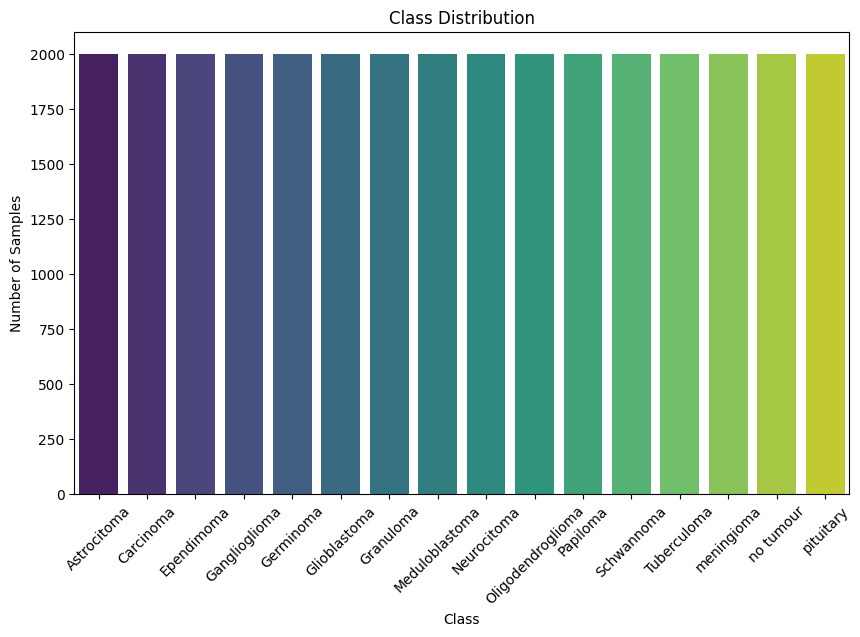


--- Displaying Sample Images from Each Class ---


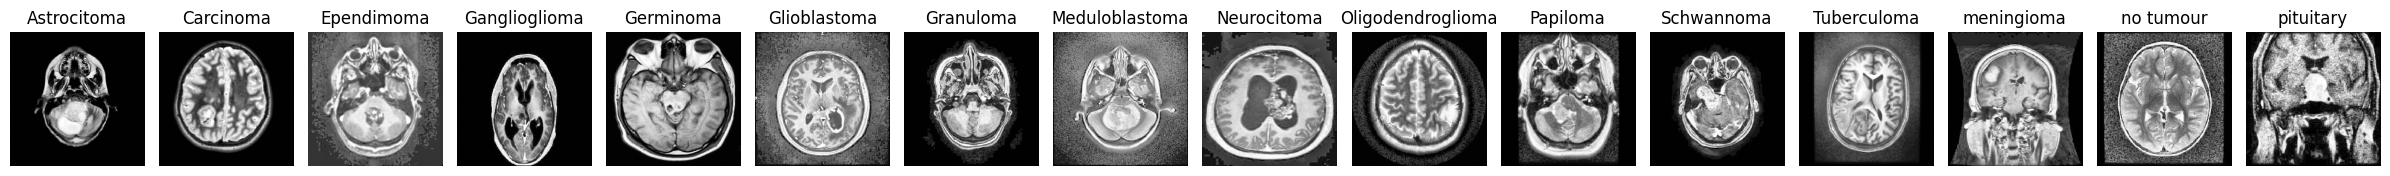


--- Image Shape and Value Distribution ---
Image Shape: (224, 224, 1)
Pixel Intensity Range: Min = 0.0, Max = 1.0


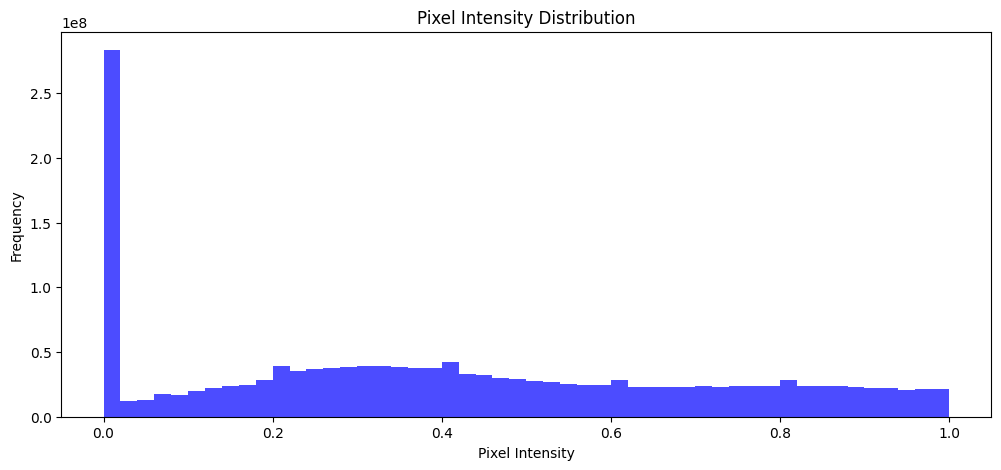


--- Checking Class Imbalance ---
Imbalance Ratio: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [50]:
# Perform EDA on the dataset
perform_eda(images, labels, class_names)

Create the Vision Transformer model

In [51]:
def create_vit_model(input_shape, num_classes, patch_size=16, embed_dim=64, num_heads=4, transformer_layers=4):
    """Build a Vision Transformer (ViT) model."""

    inputs = layers.Input(shape=input_shape)

    # Patch Embedding: Convert images into patch embeddings
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    patch_projection = layers.Conv2D(embed_dim, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)
    patches = layers.Reshape((num_patches, embed_dim))(patch_projection)

    # Learnable positional embeddings (ensure it's part of the model graph)
    positional_embedding = layers.Embedding(input_dim=num_patches, output_dim=embed_dim)(
        tf.range(start=0, limit=num_patches, delta=1)
    )
    x = patches + positional_embedding

    # Transformer Layers
    for _ in range(transformer_layers):
        # Layer Normalization before attention (Pre-Norm)
        x_norm1 = layers.LayerNormalization(epsilon=1e-6)(x)

        # Multi-head self-attention
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim // num_heads)(x_norm1, x_norm1)
        x = layers.Add()([x, attention_output])  # Residual connection

        # Layer Normalization before feed-forward (Pre-Norm)
        x_norm2 = layers.LayerNormalization(epsilon=1e-6)(x)

        # Feed-forward network
        ff_output = layers.Dense(embed_dim * 2, activation='relu')(x_norm2)
        ff_output = layers.Dense(embed_dim)(ff_output)
        x = layers.Add()([x, ff_output])  # Residual connection

    # Classification Head
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)  # Alternative to class token
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model


In [52]:
# Create the model
input_shape = (224, 224, 1)
num_classes = len(np.unique(labels))
model = create_vit_model(input_shape, num_classes)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 14, 14, 64)     │         16,448 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_5 (Reshape)       │ (None, 196, 64)        │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_61 (Add)              │ (None, 196, 64)        │              0 │ reshape_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_56    │ (None, 196, 64)        │            128 │ add_61[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_28   │ (None, 196, 64)        │         16,640 │ layer_normalization_5… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_62 (Add)              │ (None, 196, 64)        │              0 │ add_61[0][0],          │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_57    │ (None, 196, 64)        │            128 │ add_62[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_66 (Dense)          │ (None, 196, 128)       │          8,320 │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_67 (Dense)          │ (None, 196, 64)        │          8,256 │ dense_66[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_63 (Add)              │ (None, 196, 64)        │              0 │ add_62[0][0],          │
│                           │                        │                │ dense_67[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_58    │ (None, 196, 64)        │            128 │ add_63[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_29   │ (None, 196, 64)        │         16,640 │ layer_normalization_5… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_64 (Add)              │ (None, 196, 64)        │              0 │ add_63[0][0],          │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_59    │ (None, 196, 64)        │            128 │ add_64[0][0]           │
│ (LayerNormalization) 

 Total params: 160,848 (628.31 KB)

 Trainable params: 160,848 (628.31 KB)

 Non-trainable params: 0 (0.00 B)

Compile the model

In [53]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Train the model

In [54]:
# Train the model
history = model.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=70, batch_size=32)

Epoch 1/70
700/700 ━━━━━━━━━━━━━━━━━━━━ 207s 276ms/step - accuracy: 0.0959 - loss: 2.7444 - val_accuracy: 0.2380 - val_loss: 2.2877
Epoch 2/70
700/700 ━━━━━━━━━━━━━━━━━━━━ 192s 274ms/step - accuracy: 0.2363 - loss: 2.2648 - val_accuracy: 0.3748 - val_loss: 1.8938
Epoch 3/70
700/700 ━━━━━━━━━━━━━━━━━━━━ 197s 281ms/step - accuracy: 0.3642 - loss: 1.8947 - val_accuracy: 0.4721 - val_loss: 1.6124
Epoch 4/70
700/700 ━━━━━━━━━━━━━━━━━━━━ 197s 281ms/step - accuracy: 0.4675 - loss: 1.6112 - val_accuracy: 0.5497 - val_loss: 1.3686
Epoch 5/70
700/700 ━━━━━━━━━━━━━━━━━━━━ 192s 274ms/step - accuracy: 0.5653 - loss: 1.3318 - val_accuracy: 0.6493 - val_loss: 1.0431
Epoch 6/70
700/700 ━━━━━━━━━━━━━━━━━━━━ 191s 274ms/step - accuracy: 0.6309 - loss: 1.1255 - val_accuracy: 0.7385 - val_loss: 0.8340
Epoch 7/70
700/700 ━━━━━━━━━━━━━━━━━━━━ 196s 279ms/step - accuracy: 0.7069 - loss: 0.9153 - val_accuracy: 0.7245 - val_loss: 0.8409
Epoch 8/70
700/700 ━━━━━━━━━━━━━━━━━━━━ 195s 278ms/step - accuracy: 0.7480 -

Save the model

In [ ]:
#Save the model
model.save("/content/drive/MyDrive/DSGP_BrainTumorDetection/Tumor_Classisfication_ViT_Model.keras")


Evaluate the model performance

In [55]:
# Evaluate the model
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

300/300 ━━━━━━━━━━━━━━━━━━━━ 34s 112ms/step


In [56]:
# Classification Report
print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       600
           1       0.99      1.00      1.00       600
           2       0.99      0.99      0.99       600
           3       1.00      0.99      0.99       600
           4       0.99      1.00      1.00       600
           5       0.99      1.00      1.00       600
           6       0.99      0.99      0.99       600
           7       1.00      1.00      1.00       600
           8       0.97      0.98      0.97       600
           9       0.99      0.99      0.99       600
          10       0.97      0.99      0.98       600
          11       0.99      0.93      0.96       600
          12       0.95      1.00      0.98       600
          13       0.92      0.88      0.90       600
          14       0.90      0.92      0.91       600
          15       0.92      0.93      0.92       600

    accuracy                           0.97      9600
   

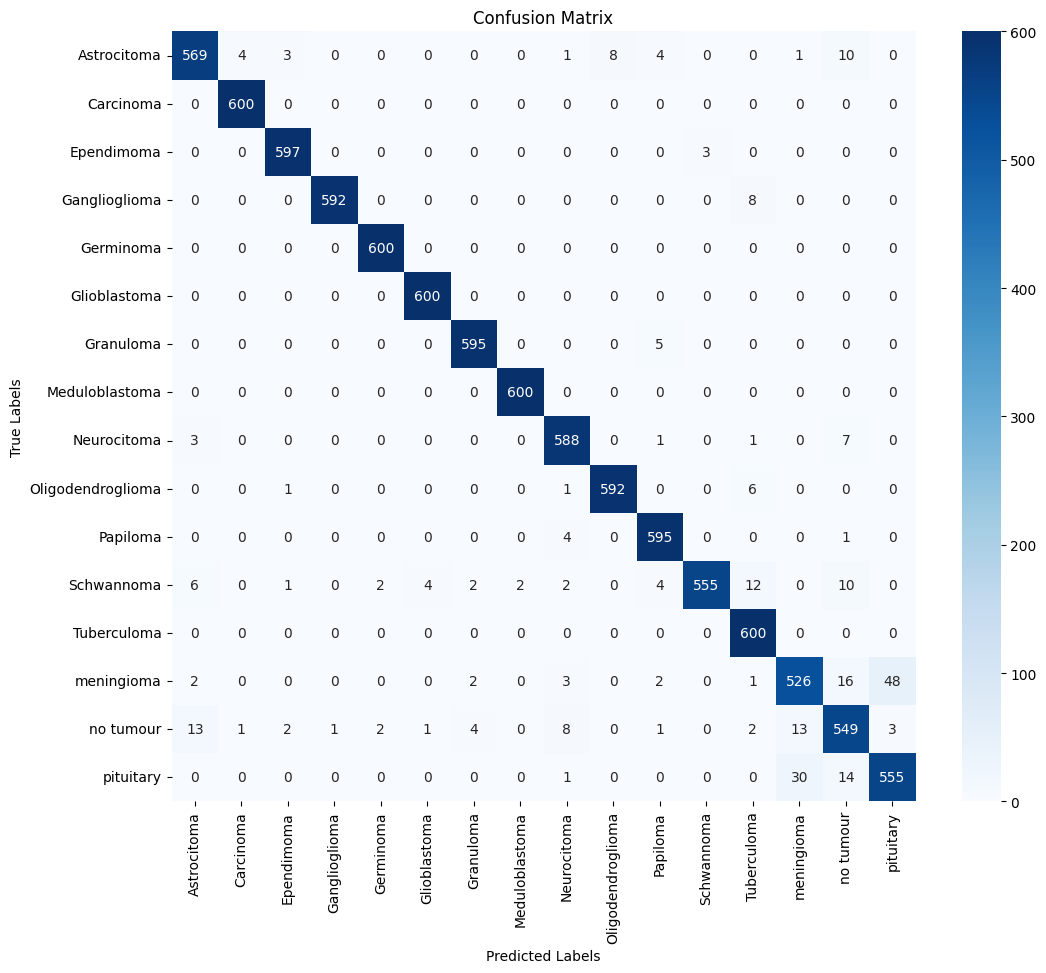

In [57]:
# Confusion Matrix
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


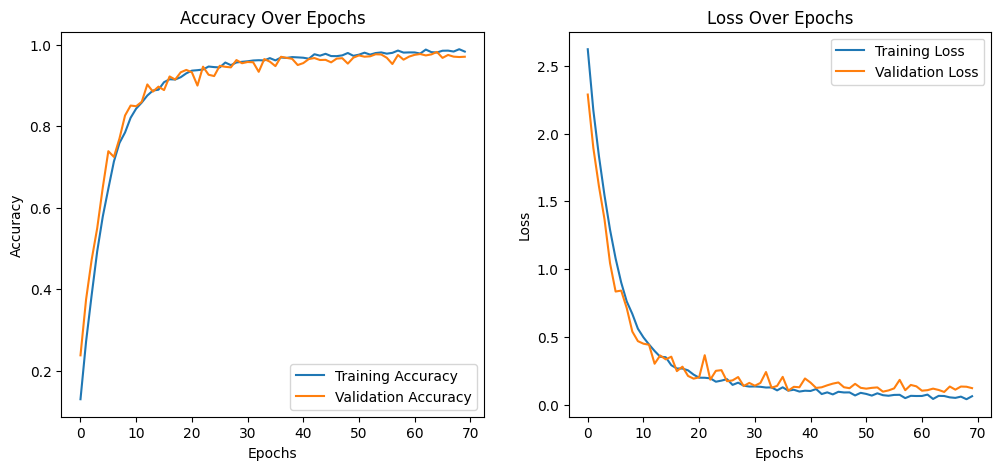

In [58]:
# Plot Training and Validation Metrics
def plot_metrics(history):
    """Plot training and validation metrics."""
    plt.figure(figsize=(12, 5))

    # Accuracy
    if 'accuracy' in history.history and 'val_accuracy' in history.history:
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_metrics(history)


Average Classification Time per Tumor Class:
Class 0: 0.081760 seconds
Class 1: 0.082875 seconds
Class 2: 0.081112 seconds
Class 3: 0.080991 seconds
Class 4: 0.081246 seconds
Class 5: 0.081315 seconds
Class 6: 0.084484 seconds
Class 7: 0.080261 seconds
Class 8: 0.080255 seconds
Class 9: 0.081189 seconds
Class 10: 0.081141 seconds
Class 11: 0.080691 seconds
Class 12: 0.082337 seconds
Class 13: 0.080210 seconds
Class 14: 0.082053 seconds
Class 15: 0.080680 seconds


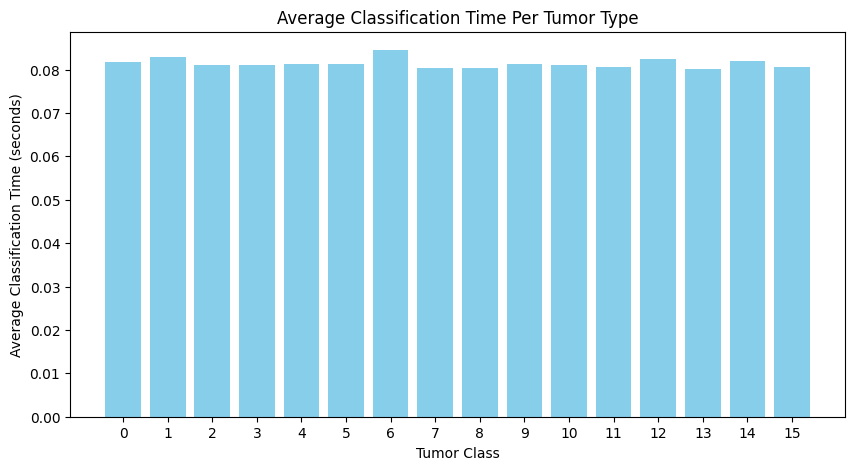

In [59]:
import time

# Dictionary to store time taken for each class
class_time = {label: [] for label in np.unique(labels)}

# Measure classification time for each test sample
for i, img in enumerate(test_images):
    start_time = time.time()  # Start timer
    pred = model.predict(tf.expand_dims(img, axis=0), verbose=0)  # Get prediction
    end_time = time.time()  # End timer

    elapsed_time = end_time - start_time  # Compute time taken
    true_class = test_labels[i]  # Get true class label
    class_time[true_class].append(elapsed_time)  # Store time taken

# Compute average classification time per class
avg_time_per_class = {label: np.mean(times) for label, times in class_time.items()}

# Print results
print("\nAverage Classification Time per Tumor Class:")
for label, time_taken in avg_time_per_class.items():
    print(f"Class {label}: {time_taken:.6f} seconds")

# Plot classification time per class
plt.figure(figsize=(10, 5))
plt.bar(avg_time_per_class.keys(), avg_time_per_class.values(), color='skyblue')
plt.xlabel("Tumor Class")
plt.ylabel("Average Classification Time (seconds)")
plt.title("Average Classification Time Per Tumor Type")
plt.xticks(ticks=np.unique(labels))  # Set x-axis labels
plt.show()
